In [24]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xarray as xr
from torch.utils.data import Dataset

np.random.seed(42)

In [25]:
ds = xr.Dataset({"data": (["sample"], np.random.rand(10))}, coords={"sample": np.arange(10)})
sampled_ds = ds[dict(sample=slice(0, 2))]
sampled_ds

<xarray.Dataset> Size: 32B
Dimensions:  (sample: 2)
Coordinates:
  * sample   (sample) int64 16B 0 1
Data variables:
    data     (sample) float64 16B 0.3745 0.9507

In [26]:
dataset_file = "./data/dataset-ucar-1979-2015-seq5-ystep5.nc"
ds = xr.open_mfdataset(dataset_file)
ds = ds[dict(sample=slice(0, 2))]
print("Coords:")
print(len(ds.coords["lat"]))
print(len(ds.coords["lon"]))
print("-" * 40)
print("Dataset dataset-ucar-1979-2015-seq5-ystep5.nc:")
ds

Coords:
32
32
----------------------------------------
Dataset dataset-ucar-1979-2015-seq5-ystep5.nc:


<xarray.Dataset> Size: 82kB
Dimensions:  (lat: 32, lon: 32, sample: 2, time: 5, channel: 1)
Coordinates:
  * lat      (lat) int32 128B -54 -52 -50 -48 -46 -44 -42 ... -4 -2 0 2 4 6 8
  * lon      (lon) int32 128B 278 280 282 284 286 288 ... 332 334 336 338 340
Dimensions without coordinates: sample, time, channel
Data variables:
    x        (sample, time, lat, lon, channel) float32 41kB dask.array<chunksize=(2, 5, 32, 32, 1), meta=np.ndarray>
    y        (sample, time, lat, lon, channel) float32 41kB dask.array<chunksize=(2, 5, 32, 32, 1), meta=np.ndarray>
Attributes:
    description:  The variables have air temperature values and are separable...

In [27]:
sample_size = 2
time_step = 3
latitude = 2
longitude = 2
channel = 1

tensor1 = torch.randn(sample_size, time_step, latitude, longitude, channel)
tensor2 = torch.randn(sample_size, channel, time_step, latitude, longitude)

same_shape = tensor1.shape == tensor2.shape
same_values = torch.equal(tensor1, tensor2)

tensor3 = tensor2[:, :, :3, :, :]
same_tensor2_tensor3 = torch.equal(tensor2, tensor3)

{
    "tensor1_shape": tensor1.shape,
    "tensor2_shape": tensor2.shape,
    "same_shape_tensor1_tensor2": same_shape,
    "same_values_tensor1_tensor2": same_values,
    "same_tensor2_tensor3": same_tensor2_tensor3,
    "tensor3_shape": tensor3.shape,
}


{'tensor1_shape': torch.Size([2, 3, 2, 2, 1]),
 'tensor2_shape': torch.Size([2, 1, 3, 2, 2]),
 'same_shape_tensor1_tensor2': False,
 'same_values_tensor1_tensor2': False,
 'same_tensor2_tensor3': True,
 'tensor3_shape': torch.Size([2, 1, 3, 2, 2])}

In [28]:
def split_train(dataset):
    return dataset[dict(sample=slice(0, 6))]


class NetCDFDataset(Dataset):
    def __init__(self, dataset):
        super(NetCDFDataset, self).__init__()
        # [batch, time, latitude, longitude, channel]
        data = split_train(dataset)
        print("estou aqui")
        print(type(data))
        # [batch, channel, time, latitude, longitude]
        self.X = torch.from_numpy(data.x.values).float().permute(0, 4, 1, 2, 3)
        print(f"data.x.shape {data.x.shape}")
        print(f"self.X.shape {self.X.shape}")
        self.X = self.X[:, :, :5, :, :]
        print(f"self.X.shape {self.X.shape}")
        self.y = torch.from_numpy(data.y.values).float().permute(0, 4, 1, 2, 3)

    def __getitem__(self, index):
        return (self.X[index, :, :, :, :], self.y[index])

    def __len__(self):
        return self.X.shape[0]

In [29]:
train_dataset = NetCDFDataset(ds)
print(len(train_dataset))
train_dataset.X.shape

estou aqui
<class 'xarray.core.dataset.Dataset'>
data.x.shape (2, 5, 32, 32, 1)
self.X.shape torch.Size([2, 1, 5, 32, 32])
self.X.shape torch.Size([2, 1, 5, 32, 32])
2


torch.Size([2, 1, 5, 32, 32])

In [30]:
data = ds[dict(sample=slice(0, 2))]
print((torch.from_numpy(data.x.values).float().permute(0, 4, 1, 2, 3)).shape)
data

torch.Size([2, 1, 5, 32, 32])


<xarray.Dataset> Size: 82kB
Dimensions:  (lat: 32, lon: 32, sample: 2, time: 5, channel: 1)
Coordinates:
  * lat      (lat) int32 128B -54 -52 -50 -48 -46 -44 -42 ... -4 -2 0 2 4 6 8
  * lon      (lon) int32 128B 278 280 282 284 286 288 ... 332 334 336 338 340
Dimensions without coordinates: sample, time, channel
Data variables:
    x        (sample, time, lat, lon, channel) float32 41kB dask.array<chunksize=(2, 5, 32, 32, 1), meta=np.ndarray>
    y        (sample, time, lat, lon, channel) float32 41kB dask.array<chunksize=(2, 5, 32, 32, 1), meta=np.ndarray>
Attributes:
    description:  The variables have air temperature values and are separable...

In [31]:
samples = 10
timesteps = 5
latitudes = 3
longitudes = 4
channels = 2

lat = np.linspace(-90, 90, latitudes)
lon = np.linspace(-180, 180, longitudes)
sample = np.arange(samples)
timestep = np.arange(timesteps)
channel = np.arange(channels)

x_data = np.random.rand(samples, timesteps, latitudes, longitudes, channels)
y_data = np.random.rand(samples, timesteps, latitudes, longitudes, channels)

ds = xr.Dataset(
    {
        "x": (["sample", "timestep", "lat", "lon", "channel"], x_data),
        "y": (["sample", "timestep", "lat", "lon", "channel"], y_data),
    },
    coords={"sample": sample, "timestep": timestep, "lat": lat, "lon": lon, "channel": channel},
)

print("Created Dataset:")
ds.to_netcdf("output_dataset.nc")
loaded_ds = xr.load_dataset("output_dataset.nc")
print("\nLoaded Dataset from NetCDF:\n", loaded_ds)


Created Dataset:

Loaded Dataset from NetCDF:
 <xarray.Dataset> Size: 19kB
Dimensions:   (sample: 10, timestep: 5, lat: 3, lon: 4, channel: 2)
Coordinates:
  * sample    (sample) int64 80B 0 1 2 3 4 5 6 7 8 9
  * timestep  (timestep) int64 40B 0 1 2 3 4
  * lat       (lat) float64 24B -90.0 0.0 90.0
  * lon       (lon) float64 32B -180.0 -60.0 60.0 180.0
  * channel   (channel) int64 16B 0 1
Data variables:
    x         (sample, timestep, lat, lon, channel) float64 10kB 0.02058 ... ...
    y         (sample, timestep, lat, lon, channel) float64 10kB 0.4262 ... 0...


In [32]:
samples = 10
timesteps = 5
latitudes = 3
longitudes = 4
channels = 2

lat = np.linspace(-90, 90, latitudes)
lon = np.linspace(-180, 180, longitudes)

sample = np.arange(samples)
timestep = np.arange(timesteps)
channel = np.arange(channels)

x_data = np.random.rand(samples, timesteps, latitudes, longitudes, channels)
y_data = np.random.rand(samples, timesteps, latitudes, longitudes, channels)

ds_bad = xr.Dataset(
    {
        "x": (["sample", "timestep", "lat", "lon", "channel"], x_data),
        "y": (["sample", "timestep", "lat", "lon", "channel"], y_data),
    },
    coords={"lat": lat, "lon": lon},
)

print("Created Dataset with lat and lon as Coordinates:")
print(ds_bad)


Created Dataset with lat and lon as Coordinates:
<xarray.Dataset> Size: 19kB
Dimensions:  (sample: 10, timestep: 5, lat: 3, lon: 4, channel: 2)
Coordinates:
  * lat      (lat) float64 24B -90.0 0.0 90.0
  * lon      (lon) float64 32B -180.0 -60.0 60.0 180.0
Dimensions without coordinates: sample, timestep, channel
Data variables:
    x        (sample, timestep, lat, lon, channel) float64 10kB 0.6883 ... 0....
    y        (sample, timestep, lat, lon, channel) float64 10kB 0.5713 ... 0....


In [33]:
sample_3_timestep_1 = ds.sel(sample=3, timestep=1, channel=1)
print("Sample 3, Timestep 1 Data:\n", sample_3_timestep_1)

Sample 3, Timestep 1 Data:
 <xarray.Dataset> Size: 272B
Dimensions:   (lat: 3, lon: 4)
Coordinates:
    sample    int64 8B 3
    timestep  int64 8B 1
  * lat       (lat) float64 24B -90.0 0.0 90.0
  * lon       (lon) float64 32B -180.0 -60.0 60.0 180.0
    channel   int64 8B 1
Data variables:
    x         (lat, lon) float64 96B 0.9308 0.429 0.7545 ... 0.4484 0.3287
    y         (lat, lon) float64 96B 0.5784 0.07942 0.8942 ... 0.6695 0.6618


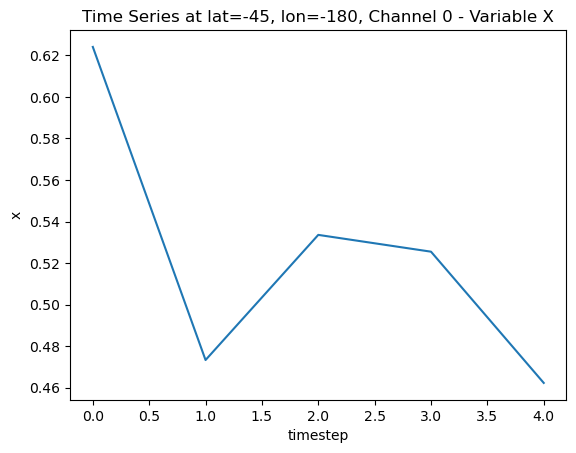

In [34]:
timeseries_data = ds.sel(lat=-45, lon=-180, channel=0, method="nearest")
timeseries_data["x"].mean(dim=["sample"]).plot()
plt.title("Time Series at lat=-45, lon=-180, Channel 0 - Variable X")
plt.show()


In [35]:
dataset_file = "./RJ_2023_9.nc"

ds = xr.open_mfdataset(dataset_file)

print("Coords:")
print(len(ds.coords["latitude"]))
print(len(ds.coords["longitude"]))

print("-" * 40)
print("Dataset:")
ds.longitude.values

lats = ds.latitude.values
lons = ds.longitude.values

Coords:
11
21
----------------------------------------
Dataset:


In [36]:
data1 = np.load("ztarget/2011_04_13_04.npy")
data2 = np.load("ztarget/2011_04_13_05.npy")
data3 = np.load("ztarget/2011_04_13_06.npy")
data4 = np.load("ztarget/2011_04_13_07.npy")
data5 = np.load("ztarget/2011_04_13_08.npy")
data1.shape

(11, 21)

In [37]:
CHANNEL = 1

a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = np.array([[9, 10], [11, 12]])
data = np.stack([a, b, c], axis=0)

data_reshape = data.reshape(data.shape[0], data.shape[1], data.shape[2], CHANNEL)
data_expand_dims = np.expand_dims(data, axis=-1)
print(np.array_equal(data_reshape, data_expand_dims))

data = np.stack([data_reshape], axis=0).shape
data

True


(1, 3, 2, 2, 1)

In [38]:
lat_sorted_ascending = np.sort(lats)[::-1]
lon_sorted_ascending = np.sort(lons)

sample = np.arange(1)
timestep = np.arange(5)
channel = np.arange(1)

data1 = np.load("ztarget/2011_04_13_04.npy")
data2 = np.load("ztarget/2011_04_13_05.npy")
data3 = np.load("ztarget/2011_04_13_06.npy")
data4 = np.load("ztarget/2011_04_13_07.npy")
data5 = np.load("ztarget/2011_04_13_08.npy")

data = np.stack([data1, data2, data3, data4, data5], axis=0)
print(f"data after stacking 5 timestamps: {data.shape}")
data = data.reshape(data.shape[0], data.shape[1], data.shape[2], CHANNEL)
print(f"data after reshaping to 1 channel: {data.shape}")
data = np.stack([data], axis=0)
print(f"data after stacking samples: {data.shape}")

ds = xr.Dataset(
    {
        "data": (
            ["sample", "timestep", "lat", "lon", "channel"],
            data,
        )
    },
    coords={
        "sample": sample,
        "timestep": timestep,
        "lat": lat_sorted_ascending,
        "lon": lon_sorted_ascending,
        "channel": channel,
    },
)

print("Created Dataset:")
print(ds)

data after stacking 5 timestamps: (5, 11, 21)
data after reshaping to 1 channel: (5, 11, 21, 1)
data after stacking samples: (1, 5, 11, 21, 1)
Created Dataset:
<xarray.Dataset> Size: 9kB
Dimensions:   (sample: 1, timestep: 5, lat: 11, lon: 21, channel: 1)
Coordinates:
  * sample    (sample) int64 8B 0
  * timestep  (timestep) int64 40B 0 1 2 3 4
  * lat       (lat) float32 44B -22.0 -22.1 -22.2 -22.3 ... -22.8 -22.9 -23.0
  * lon       (lon) float32 84B -44.0 -43.9 -43.8 -43.7 ... -42.2 -42.1 -42.0
  * channel   (channel) int64 8B 0
Data variables:
    data      (sample, timestep, lat, lon, channel) float64 9kB 0.0 0.0 ... 0.0


In [39]:
lat_sorted_ascending = np.sort(lats)[::-1]
lon_sorted_ascending = np.sort(lons)

sample = np.arange(2)
timestep = np.arange(5)
channel = np.arange(1)

data1_sample1 = np.load("ztarget/2011_04_13_04.npy")
data2_sample1 = np.load("ztarget/2011_04_13_05.npy")
data3_sample1 = np.load("ztarget/2011_04_13_06.npy")
data4_sample1 = np.load("ztarget/2011_04_13_07.npy")
data5_sample1 = np.load("ztarget/2011_04_13_08.npy")

data1_sample2 = np.load("ztarget/2011_04_13_04.npy")
data2_sample2 = np.load("ztarget/2011_04_13_05.npy")
data3_sample2 = np.load("ztarget/2011_04_13_06.npy")
data4_sample2 = np.load("ztarget/2011_04_13_07.npy")
data5_sample2 = np.load("ztarget/2011_04_13_08.npy")

data_sample1 = np.stack(
    [data1_sample1, data2_sample1, data3_sample1, data4_sample1, data5_sample1], axis=0
)
data_sample1 = data_sample1.reshape(
    data_sample1.shape[0], data_sample1.shape[1], data_sample1.shape[2], len(channel)
)
data_sample2 = np.stack(
    [data1_sample2, data2_sample2, data3_sample2, data4_sample2, data5_sample2], axis=0
)
data_sample2 = data_sample2.reshape(
    data_sample2.shape[0], data_sample2.shape[1], data_sample2.shape[2], len(channel)
)
print(f"data_sample1 after stacking 5 timestamps and reshaping to 1 channel: {data_sample1.shape}")
print(f"data_sample2 after stacking 5 timestamps and reshaping to 1 channel: {data_sample2.shape}")

data = np.stack([data_sample1, data_sample2], axis=0)
print(f"data after stacking samples: {data.shape}")

ds = xr.Dataset(
    {"data": (["sample", "timestep", "lat", "lon", "channel"], data)},
    coords={
        "sample": sample,
        "timestep": timestep,
        "lat": lat_sorted_ascending,
        "lon": lon_sorted_ascending,
        "channel": channel,
    },
)

print("Created Dataset:")
print(ds)


data_sample1 after stacking 5 timestamps and reshaping to 1 channel: (5, 11, 21, 1)
data_sample2 after stacking 5 timestamps and reshaping to 1 channel: (5, 11, 21, 1)
data after stacking samples: (2, 5, 11, 21, 1)
Created Dataset:
<xarray.Dataset> Size: 19kB
Dimensions:   (sample: 2, timestep: 5, lat: 11, lon: 21, channel: 1)
Coordinates:
  * sample    (sample) int64 16B 0 1
  * timestep  (timestep) int64 40B 0 1 2 3 4
  * lat       (lat) float32 44B -22.0 -22.1 -22.2 -22.3 ... -22.8 -22.9 -23.0
  * lon       (lon) float32 84B -44.0 -43.9 -43.8 -43.7 ... -42.2 -42.1 -42.0
  * channel   (channel) int64 8B 0
Data variables:
    data      (sample, timestep, lat, lon, channel) float64 18kB 0.0 0.0 ... 0.0


In [40]:
def get_min_max_timestamps():
    folder_path = Path("ztarget")
    min_timestamp = pd.Timestamp.max
    max_timestamp = pd.Timestamp.min
    for file in folder_path.glob("*.npy"):
        date_str = file.stem
        date_obj = datetime.strptime(date_str, "%Y_%m_%d_%H")
        date_ts = pd.Timestamp(date_obj)
        if date_ts < min_timestamp:
            min_timestamp = date_ts
        if date_ts > max_timestamp:
            max_timestamp = date_ts
    return min_timestamp, max_timestamp


min_timestamp, max_timestamp = get_min_max_timestamps()
print(f"Minimum date: {min_timestamp}")
print(f"Maximum date: {max_timestamp}")

Minimum date: 2011-04-13 01:00:00
Maximum date: 2011-04-13 10:00:00


In [41]:
timestamps = pd.date_range(start=min_timestamp, end=max_timestamp, freq="h")


def has_timesteps(year, month, day, hour, timesteps) -> bool:
    for timestep in range(timesteps):
        file = f"ztarget/{year:04}_{month:02}_{day:02}_{(hour - timestep):02}.npy"
        if not Path(file).exists():
            return False
    return True


def get_dataset_with_timesteps(
    year: int, month: int, day: int, hour: int, channel: int = 1, time_step: int = 5
) -> np.ndarray:
    timesteps = []
    for timestep in range(time_step):
        file = f"{year:04}_{month:02}_{day:02}_{(hour - timestep):02}.npy"
        data = np.load(f"ztarget/{file}")
        timesteps.append(data)
    data = np.stack(timesteps, axis=0)
    data = data.reshape(data.shape[0], data.shape[1], data.shape[2], channel)
    return data


timesteps = 5

data_list = []
for timestamp in timestamps:
    year = timestamp.year
    month = timestamp.month
    day = timestamp.day
    hour = timestamp.hour
    if not has_timesteps(year, month, day, hour, timesteps):
        continue
    print(f"Loading data for {year:02}-{month:02}-{day:02} {hour}:00")
    numpy_dataset = get_dataset_with_timesteps(year, month, day, hour)
    data_list.append(numpy_dataset)

assert len(data_list) == len(timestamps) - timesteps + 1, "Missing data for some timestamps"
data_x = np.stack(data_list, axis=0)

"""
The problem with the code above is that it doesn't account for data_y. To build data_x and data_y each with 5 timestamps,
and data_y being the next 5 timestamps after data_x, we need to adjust the code to load the data for data_y as well. The minimum amount of timestamps we need is 10, since 5 for data_x and next 5 for data_y.

The cell code below handles it
"""
data_x.shape

Loading data for 2011-04-13 5:00
Loading data for 2011-04-13 6:00
Loading data for 2011-04-13 7:00
Loading data for 2011-04-13 8:00
Loading data for 2011-04-13 9:00
Loading data for 2011-04-13 10:00


(6, 5, 11, 21, 1)

In [42]:
# sliding window
N = ["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T10", "T11"]
WINDOW_SIZE = 5 * 2
total_samples = len(N) - WINDOW_SIZE + 1
total_samples

2

In [43]:
timestamps = pd.date_range(start=min_timestamp, end=max_timestamp, freq="h")


def has_timesteps(year, month, day, hour, timesteps) -> bool:
    for timestep in range(timesteps):
        file = f"ztarget/{year:04}_{month:02}_{day:02}_{(hour - timestep):02}.npy"
        if not Path(file).exists():
            return False
    return True


def get_dataset_with_timesteps(
    year: int, month: int, day: int, hour: int, channel: int = 1, time_step: int = 5
) -> np.ndarray:
    timesteps = []
    for timestep in range(time_step):
        file = f"{year:04}_{month:02}_{day:02}_{(hour - timestep):02}.npy"
        data = np.load(f"ztarget/{file}")
        timesteps.append(data)
    data = np.stack(timesteps, axis=0)
    data = data.reshape(data.shape[0], data.shape[1], data.shape[2], channel)
    return data


timesteps = 5

data_x_list = []
data_y_list = []

for timestamp in timestamps[:-timesteps]:
    year = timestamp.year
    month = timestamp.month
    day = timestamp.day
    hour = timestamp.hour

    if not has_timesteps(year, month, day, hour, timesteps):
        continue
    if not has_timesteps(year, month, day, hour + timesteps, timesteps):
        continue

    print(f"Loading data_x for {year:02}-{month:02}-{day:02} {hour}:00")
    numpy_data_x = get_dataset_with_timesteps(year, month, day, hour)

    print(f"Loading data_y for {year:02}-{month:02}-{day:02} {hour+timesteps}:00")
    numpy_data_y = get_dataset_with_timesteps(year, month, day, hour + timesteps)

    data_x_list.append(numpy_data_x)
    data_y_list.append(numpy_data_y)

assert len(data_x_list) == len(data_y_list), "Mismatch between data_x and data_y"
assert len(data_x_list) == len(timestamps) - 2 * timesteps + 1, "Missing data for some timestamps"
data_x = np.stack(data_x_list, axis=0)
data_y = np.stack(data_y_list, axis=0)

assert timesteps == data_x.shape[1] == data_y.shape[1], "Mismatch between timesteps"

print(f"data_x shape: {data_x.shape}")
print(f"data_y shape: {data_y.shape}")

sample = np.arange(data_x.shape[0])
timestep = np.arange(data_x.shape[1])
lat_sorted_ascending = np.sort(lats)[::-1]
lon_sorted_ascending = np.sort(lons)
channel = np.arange(data_x.shape[4])

ds = xr.Dataset(
    {
        "x": (["sample", "timestep", "lat", "lon", "channel"], data_x),
        "y": (["sample", "timestep", "lat", "lon", "channel"], data_y),
    },
    coords={
        "sample": sample,
        "timestep": timestep,
        "lat": lat_sorted_ascending,
        "lon": lon_sorted_ascending,
        "channel": channel,
    },
)

print(ds)
ds.to_netcdf("output_dataset.nc")
loaded_ds = xr.load_dataset("output_dataset.nc")
print("\nLoaded Dataset from NetCDF:\n", loaded_ds)

"""

The code above correct creates data_x and data_y, but we have issues in the way we handle the timesteps. For example doing hour + timesteps or hour - timeteps could lead to negative values or values greater than 23. We need to adjust the code to handle this correctly, 23 + 1 should be 00:00 of the next day and 00 - 1 should be 23:00 of the previous day

The cell code below handles it
"""

Loading data_x for 2011-04-13 5:00
Loading data_y for 2011-04-13 10:00
data_x shape: (1, 5, 11, 21, 1)
data_y shape: (1, 5, 11, 21, 1)
<xarray.Dataset> Size: 19kB
Dimensions:   (sample: 1, timestep: 5, lat: 11, lon: 21, channel: 1)
Coordinates:
  * sample    (sample) int64 8B 0
  * timestep  (timestep) int64 40B 0 1 2 3 4
  * lat       (lat) float32 44B -22.0 -22.1 -22.2 -22.3 ... -22.8 -22.9 -23.0
  * lon       (lon) float32 84B -44.0 -43.9 -43.8 -43.7 ... -42.2 -42.1 -42.0
  * channel   (channel) int64 8B 0
Data variables:
    x         (sample, timestep, lat, lon, channel) float64 9kB 0.0 0.0 ... 0.0
    y         (sample, timestep, lat, lon, channel) float64 9kB 0.0 0.0 ... 0.0

Loaded Dataset from NetCDF:
 <xarray.Dataset> Size: 19kB
Dimensions:   (sample: 1, timestep: 5, lat: 11, lon: 21, channel: 1)
Coordinates:
  * sample    (sample) int64 8B 0
  * timestep  (timestep) int64 40B 0 1 2 3 4
  * lat       (lat) float32 44B -22.0 -22.1 -22.2 -22.3 ... -22.8 -22.9 -23.0
  * lon     

'\n\nThe code above correct creates data_x and data_y, but we have issues in the way we handle the timesteps. For example doing hour + timesteps or hour - timeteps could lead to negative values or values greater than 23. We need to adjust the code to handle this correctly, 23 + 1 should be 00:00 of the next day and 00 - 1 should be 23:00 of the previous day\n\nThe cell code below handles it\n'

In [44]:
print(pd.Timestamp(year=2023, month=4, day=13, hour=23) + pd.Timedelta(hours=1))
print(pd.Timestamp(year=2023, month=4, day=13, hour=00) - pd.Timedelta(hours=1))

2023-04-14 00:00:00
2023-04-12 23:00:00


In [45]:
timestamps = pd.date_range(start=min_timestamp, end=max_timestamp, freq="h")


def has_timesteps(year, month, day, hour, timesteps) -> bool:
    start_time = pd.Timestamp(year=year, month=month, day=day, hour=hour)

    for timestep in range(timesteps):
        current_time = start_time - pd.Timedelta(hours=timestep)
        file = f"ztarget/{current_time.year:04}_{current_time.month:02}_{current_time.day:02}_{current_time.hour:02}.npy"
        if not Path(file).exists():
            return False
    return True


def get_dataset_with_timesteps(
    year: int, month: int, day: int, hour: int, channel: int = 1, time_step: int = 5
) -> np.ndarray:
    start_time = pd.Timestamp(year=year, month=month, day=day, hour=hour)
    timesteps = []

    for timestep in range(time_step):
        current_time = start_time - pd.Timedelta(hours=timestep)
        file = f"ztarget/{current_time.year:04}_{current_time.month:02}_{current_time.day:02}_{current_time.hour:02}.npy"

        try:
            data = np.load(file)
        except Exception as e:
            print(f"Error loading file {file}: {e}")
            exit(1)

        timesteps.append(data)

    data = np.stack(timesteps, axis=0)
    data = data.reshape(data.shape[0], data.shape[1], data.shape[2], channel)
    return data


timesteps = 5

data_x_list = []
data_y_list = []

for timestamp in timestamps[:-timesteps]:
    year = timestamp.year
    month = timestamp.month
    day = timestamp.day
    hour = timestamp.hour

    if not has_timesteps(year, month, day, hour, timesteps):
        continue

    numpy_data_x = get_dataset_with_timesteps(year, month, day, hour)

    next_timestamp = timestamp + pd.Timedelta(hours=timesteps)
    year_y = next_timestamp.year
    month_y = next_timestamp.month
    day_y = next_timestamp.day
    hour_y = next_timestamp.hour

    if not has_timesteps(year_y, month_y, day_y, hour_y, timesteps):
        continue

    numpy_data_y = get_dataset_with_timesteps(year_y, month_y, day_y, hour_y)

    data_x_list.append(numpy_data_x)
    data_y_list.append(numpy_data_y)

assert len(data_x_list) == len(data_y_list), "Mismatch between data_x and data_y lists."
assert (
    len(data_x_list) == len(timestamps) - 2 * timesteps + 1
), f"Expected {len(timestamps) - 2 * timesteps + 1} samples, but got {len(data_x_list)}."

data_x = np.stack(data_x_list, axis=0)
data_y = np.stack(data_y_list, axis=0)

assert timesteps == data_x.shape[1] == data_y.shape[1], "Mismatch between timesteps"

lat_sorted_ascending = np.sort(lats)[::-1]
lon_sorted_ascending = np.sort(lons)
sample = np.arange(data_x.shape[0])
timestep = np.arange(data_x.shape[1])
channel = np.arange(data_x.shape[4])

ds = xr.Dataset(
    {
        "x": (["sample", "timestep", "lat", "lon", "channel"], data_x),
        "y": (["sample", "timestep", "lat", "lon", "channel"], data_y),
    },
    coords={
        "sample": sample,
        "timestep": timestep,
        "lat": lat_sorted_ascending,
        "lon": lon_sorted_ascending,
        "channel": channel,
    },
)

ds.to_netcdf("output_dataset.nc")
loaded_ds = xr.load_dataset("output_dataset.nc")
loaded_ds

<xarray.Dataset> Size: 19kB
Dimensions:   (sample: 1, timestep: 5, lat: 11, lon: 21, channel: 1)
Coordinates:
  * sample    (sample) int64 8B 0
  * timestep  (timestep) int64 40B 0 1 2 3 4
  * lat       (lat) float32 44B -22.0 -22.1 -22.2 -22.3 ... -22.8 -22.9 -23.0
  * lon       (lon) float32 84B -44.0 -43.9 -43.8 -43.7 ... -42.2 -42.1 -42.0
  * channel   (channel) int64 8B 0
Data variables:
    x         (sample, timestep, lat, lon, channel) float64 9kB 0.0 0.0 ... 0.0
    y         (sample, timestep, lat, lon, channel) float64 9kB 0.0 0.0 ... 0.0